In [1]:
import torch

# Check if PyTorch is installed
print("PyTorch Version:", torch.__version__)

# Check available devices
print("Is CUDA available?", torch.cuda.is_available())  # False on Mac
print("Is MPS available?", torch.backends.mps.is_available())  # True on Apple Silicon


PyTorch Version: 2.6.0
Is CUDA available? False
Is MPS available? True


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
x = torch.tensor([1.0, 2.0, 3.0]).to(device)
print(x)


tensor([1., 2., 3.], device='mps:0')


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

# Use MPS for Apple Silicon or CPU if unavailable
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load Pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Modify last layer for 2 classes
model = model.to(device)

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Data (Assumes dataset/train/ and dataset/val/)
train_dataset = datasets.ImageFolder("datasets/cats-v-dogs/training", transform=transform)
val_dataset = datasets.ImageFolder("datasets/cats-v-dogs/validation", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# Train Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# Save Model
torch.save(model.state_dict(), "resnet50_mps.pth")
print("Model saved successfully!")


/opt/anaconda3/envs/dogscats/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1, Loss: 0.0453, Accuracy: 98.47%
Epoch 2, Loss: 0.0155, Accuracy: 99.52%
Epoch 3, Loss: 0.0117, Accuracy: 99.64%
Epoch 4, Loss: 0.0052, Accuracy: 99.84%
Epoch 5, Loss: 0.0148, Accuracy: 99.71%
Model saved successfully!


In [8]:
from PIL import Image

# Load the saved model
model.load_state_dict(torch.load("resnet50_mps.pth"))
model.eval()

# Function to predict
def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        
    # Get class name
    class_names = ['cat', 'dog']  # Based on your dataset structure
    return class_names[predicted.item()]

Predicted class: dog


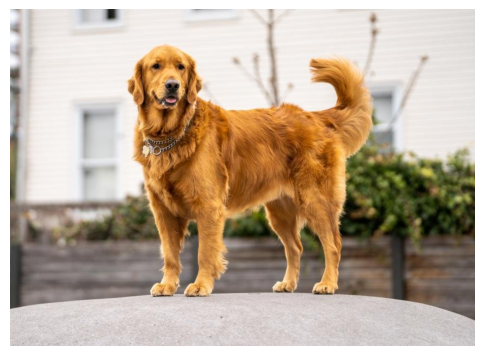

In [9]:
# Example usage
import requests
from io import BytesIO
import matplotlib.pyplot as plt

test_image_url = "https://images.squarespace-cdn.com/content/v1/54822a56e4b0b30bd821480c/45ed8ecf-0bb2-4e34-8fcf-624db47c43c8/Golden+Retrievers+dans+pet+care.jpeg"
response = requests.get(test_image_url)
image_data = BytesIO(response.content)

try:
    prediction = predict_image(image_data)
    print(f"Predicted class: {prediction}")
except Exception as e:
    print(f"Error processing image: {str(e)}")


img = Image.open(image_data)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()